In [1]:
from PIL import Image
import tensorflow as tf
import scipy.ndimage
from scipy import misc
from scipy.interpolate import RectBivariateSpline
import numpy as np
import numpy.matlib as ml
import random
import time
import os
import gc
import scipy.io
slim = tf.contrib.slim
sess = tf.InteractiveSession()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_out = 5    #number ouf output parameters being predicted
global numpix_side
numpix_side = 192   #number of image pixels on the side
global max_noise_rms, max_psf_rms , max_cr_intensity
max_trainoise_rms = 0.1 # maximum rms of noise in training data
max_testnoise_rms = 0.1 # maximum rms of noise in test or validation data
max_noise_rms = max_testnoise_rms

max_psf_rms = 0.08/0.04  # maximum Gaussian PSF rms (in pixels)
max_cr_intensity = 0.5 # maximum scaling for cosmic ray and artefact maps

global constant_noise_rms
variable_noise_rms = True  #if True, the noise rms will be chosen randomly for each sample with a max of max_noise_rms (above)


cycle_batch_size = 50   # how many examples to read at a time (here it's equal to the batch size)
num_test_samples = 1000 # number of test samples

global pix_res
pix_res = 0.04 # pixel size in arcsec
L_side = pix_res * numpix_side

global arcs_data_path_1, arcs_data_path_2 , test_data_path_1 , test_data_path_2 , CRay_data_path
global lens_data_path_1, lens_data_path_2, testlens_data_path_1, testlens_data_path_2

global min_unmasked_flux
min_unmasked_flux = 0.75

global num_data_dirs
num_data_dirs = 3

num_training_samples = 100000
max_num_test_samples = 10000
arcs_data_path_1 = 'data/SAURON_TEST/'
arcs_data_path_2 = arcs_data_path_1
arcs_data_path_3 = arcs_data_path_1
test_data_path_1 = 'data/SAURON_TEST/'
test_data_path_2 = test_data_path_1
test_data_path_3 = test_data_path_1

lens_data_path_1 = 'data/SAURON_TEST/'
lens_data_path_2 = lens_data_path_1
lens_data_path_3 = lens_data_path_1
testlens_data_path_1 = 'data/SAURON_TEST/'
testlens_data_path_2 = testlens_data_path_1
testlens_data_path_3 = testlens_data_path_1

CRay_data_path   = 'data/CosmicRays/'

global max_xy_range   # xy range of center of the lens. The image is shifted in a central area with a side of max_xy_range (arcsec) during training or testing
max_xy_range = 0.5

In [3]:
execfile("get_data.py")

In [4]:
x = tf.placeholder(tf.float32, shape=[None, numpix_side*numpix_side])   #placeholder for input image
y_ = tf.placeholder(tf.float32, shape=[None,num_out])    #placeholder for output parameters during training
x_image0 = tf.reshape(x, [-1,numpix_side,numpix_side,1])

In [5]:
# removing image intensity bias: filter image with a 4X4 filter and remove from image
MASK = tf.abs(tf.sign(x_image0))
XX =  x_image0 +  ( (1-MASK) * 1000.0)
bias_measure_filt = tf.constant((1.0/16.0), shape=[4, 4, 1, 1])
bias_measure = tf.nn.conv2d( XX , bias_measure_filt , strides=[1, 1, 1, 1], padding='VALID')
im_bias = tf.reshape( tf.reduce_min(bias_measure,axis=[1,2,3]) , [-1,1,1,1] )
x_image = x_image0 - (im_bias * MASK )

In [6]:
# construct all models (networks):
execfile("ensai_model.py")

In [7]:
# make an instance of AlexNet (model 9):
with tf.variable_scope("ENSAI"):
    y_conv = model_9(x_image,scope="EN_Model9"  )

In [8]:
variables_to_restore =  slim.get_variables(scope="ENSAI/EN_Model9" )   #list of variables to restore
restore_file = "data/trained_weights/model_9.ckpt"
restorer = tf.train.Saver(variables_to_restore)
sess.run(tf.global_variables_initializer())      #initialize variables
restorer.restore(sess, restore_file)             # restore our saved weights

In [9]:
MeanSquareCost , y_conv_flipped = cost_tensor(y_conv)

In [10]:
# read some lens image files from the disk and add observational effects to them:

max_xy_range = 0.5  # xy range of center of the lens. The image is shifted in a central area with a side of max_xy_range (arcsec) during training or testing
variable_noise_rms = True   #if True, the noise rms will be chosen randomly for each sample with a max of max_noise_rms
max_noise_rms = 0.1  # maximum rms of noise data
num_samp = 1000   #number of test samples
chunk_size = 50    # batch number: how many test examples to pass at one time.

X = np.zeros( ( num_samp , numpix_side * numpix_side ), dtype='float32') ;   #numpy array holding the images
Y = np.zeros( ( num_samp , num_out ) , dtype='float32' );                    #numpy array holding the lens parameters (here only used to flip for the x-y ellipticity)
Predictions = np.zeros( ( num_samp , num_out ) , dtype='float32' );          #predicted parameters
mag = np.zeros((num_samp,1))
read_data_batch( X , Y , mag , max_num_test_samples  , 'test')             #read data


In [11]:
cost = 0.0
ind_t = range(num_samp)
sum_rms = 0
num_chunks = num_samp/chunk_size

#loop over our samples (since we can't give all the test data at once because of limited gpu memory)
for it in range(num_chunks):
        print it
        xA = X[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]
        yA = Y[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]
        cost  = cost + sess.run(MeanSquareCost, feed_dict={x: xA, y_: yA})   # evaluate cost
        A = sess.run(y_conv , feed_dict={ x: xA})   # A is the network prediction for parameters
        B = sess.run(y_conv_flipped , feed_dict={ x: xA})  # B is the same prediction with the ellipticity flipped
        Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]  = get_rotation_corrected(A,B,Y[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])  # "Prediction" is now corrected for the flip.
        sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] -Y[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
        print('rms error is ' + np.array_str( sum_rms/it  ,precision=2) )

0


/Users/yashar/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide


rms error is [ inf  inf  inf  inf  inf]
1
rms error is [ 0.07  0.14  0.15  0.18  0.16]
2
rms error is [ 0.06  0.1   0.11  0.13  0.12]
3
rms error is [ 0.05  0.09  0.09  0.11  0.09]
4
rms error is [ 0.05  0.09  0.09  0.1   0.09]
5
rms error is [ 0.04  0.08  0.08  0.1   0.09]
6
rms error is [ 0.04  0.08  0.08  0.1   0.09]
7
rms error is [ 0.04  0.08  0.08  0.09  0.09]
8
rms error is [ 0.04  0.08  0.08  0.09  0.09]
9
rms error is [ 0.04  0.08  0.08  0.09  0.09]
10
rms error is [ 0.04  0.08  0.08  0.09  0.08]
11
rms error is [ 0.04  0.08  0.08  0.09  0.08]
12
rms error is [ 0.04  0.08  0.08  0.09  0.08]
13
rms error is [ 0.04  0.08  0.08  0.09  0.08]
14
rms error is [ 0.04  0.08  0.08  0.09  0.08]
15
rms error is [ 0.04  0.07  0.08  0.09  0.08]
16
rms error is [ 0.04  0.07  0.08  0.09  0.08]
17
rms error is [ 0.04  0.07  0.07  0.08  0.08]
18
rms error is [ 0.04  0.07  0.07  0.09  0.08]
19
rms error is [ 0.04  0.07  0.07  0.09  0.09]


[-0.4, 0.4, -0.4, 0.4]

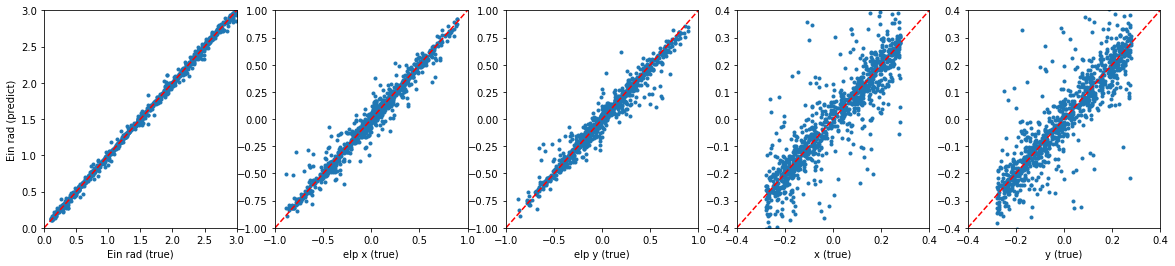

In [12]:
# And here's the fun part:
# plot the recovered parameters (y-axis) against their true values (x-axis)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.plot(Y[:,0],Predictions[:,0],' .')
plt.plot([0 , 3.],[0 , 3.],'--r')
plt.xlabel("Ein rad (true)")
plt.ylabel("Ein rad (predict)")
plt.axis([0 ,3 ,0 ,3])

plt.subplot(1, 5, 2)
plt.plot(Y[:,1],Predictions[:,1],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp x (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 3)
plt.plot(Y[:,2],Predictions[:,2],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp y (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 4)
plt.plot(Y[:,3],Predictions[:,3],' .')
plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("x (true)")
plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])


plt.subplot(1, 5, 5)
plt.plot(Y[:,4],Predictions[:,4],' .')
plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("y (true)")
plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])


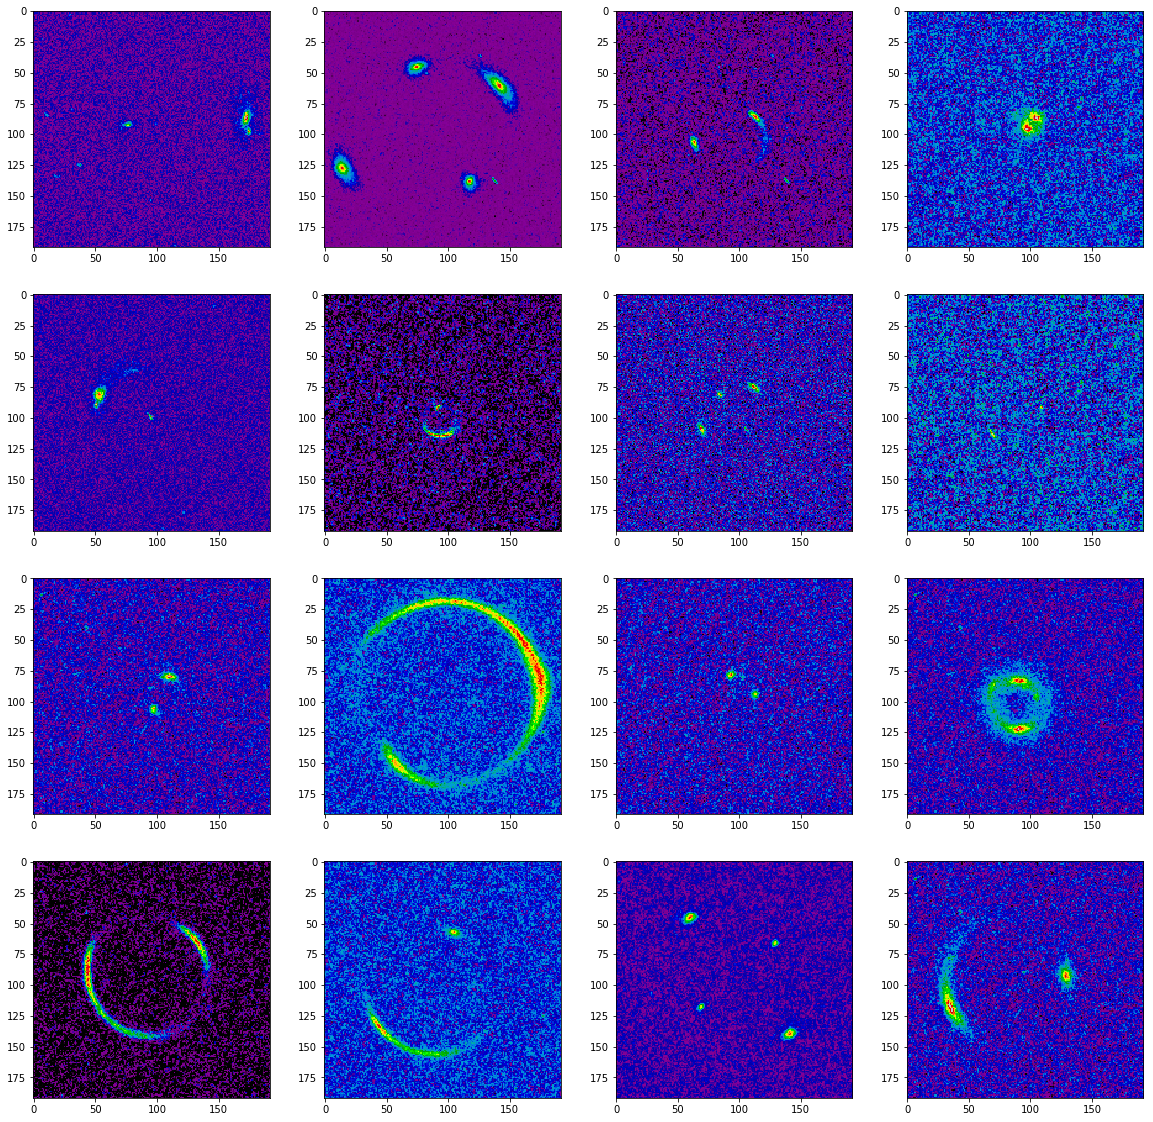

In [13]:
# Show a few example of the lenses
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X[[i]].reshape(numpix_side,numpix_side),vmin=-0.15,vmax=1.0,cmap='nipy_spectral')